In [317]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
#sklearn onehotencoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
impute = KNNImputer()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss


from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import Callback, EarlyStopping, EpochScoring

In [318]:
df=pd.read_csv("speeddating.csv", sep=",")
df.columns

Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
       'race', 'race_o', 'samerace',
       ...
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'like',
       'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision',
       'decision_o', 'match'],
      dtype='object', length=123)

EDA

In [319]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_null,8378.0,0.874910,0.330840,0.0,1.0,1.0,1.0,1.0
wave,8378.0,11.350919,5.995903,1.0,7.0,11.0,15.0,21.0
d_age,8378.0,4.185605,4.596171,0.0,1.0,3.0,5.0,37.0
samerace,8378.0,0.395799,0.489051,0.0,0.0,0.0,1.0,1.0
decision,8378.0,0.419909,0.493573,0.0,0.0,0.0,1.0,1.0
decision_o,8378.0,0.419551,0.493515,0.0,0.0,0.0,1.0,1.0
match,8378.0,0.164717,0.370947,0.0,0.0,0.0,0.0,1.0


In [320]:
df.describe(exclude=np.number)

,gender,age,age_o,d_d_age,race,race_o,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
count,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,...,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378
unique,2,31,25,4,6,6,18,16,3,3,...,19,18,3,3,3,19,20,3,3,8
top,male,27,27,[2-3],European/Caucasian-American,European/Caucasian-American,1,1,[2-5],[0-1],...,?,2,[5-6],[0-3],[0-2],7,5,[6-8],[5-6],0
freq,4194,1037,1059,2406,4727,4722,2754,2944,3104,3111,...,6578,1695,4036,7346,4514,1816,1799,4827,3199,7644


In [321]:
#Pozrel som sa ako vyzerajú dáta
df.age.unique()

array(['21', '24', '25', '23', '22', '26', '27', '30', '28', '?', '29',
       '34', '35', '32', '39', '20', '19', '18', '37', '33', '36', '31',
       '42', '38', '55', 23, 24, 30, 28, 27, 25], dtype=object)

In [322]:
#kukol som či tu sú duplikáty
print("Duplicates:")
duplicates = df.duplicated()
print(df[duplicates])


Duplicates:
Empty DataFrame
Columns: [has_null, wave, gender, age, age_o, d_age, d_d_age, race, race_o, samerace, importance_same_race, importance_same_religion, d_importance_same_race, d_importance_same_religion, field, pref_o_attractive, pref_o_sincere, pref_o_intelligence, pref_o_funny, pref_o_ambitious, pref_o_shared_interests, d_pref_o_attractive, d_pref_o_sincere, d_pref_o_intelligence, d_pref_o_funny, d_pref_o_ambitious, d_pref_o_shared_interests, attractive_o, sinsere_o, intelligence_o, funny_o, ambitous_o, shared_interests_o, d_attractive_o, d_sinsere_o, d_intelligence_o, d_funny_o, d_ambitous_o, d_shared_interests_o, attractive_important, sincere_important, intellicence_important, funny_important, ambtition_important, shared_interests_important, d_attractive_important, d_sincere_important, d_intellicence_important, d_funny_important, d_ambtition_important, d_shared_interests_important, attractive, sincere, intelligence, funny, ambition, d_attractive, d_sincere, d_intelligence

Okej, máme missing values v podobe '?' ale nie duplikáty

In [323]:
# Nahrada NaN/<NA> za ?, oprava rôznych data typov v stĺpci, následna oprava opravy naspäť na int z float(kvôli NaN)
df = df.replace("?", np.nan)


#Keďže dropnutie všetkých NaN spôsobí stratu 80% dát, treba imputovať kde sa dá

# match, gender, akékoľvek descison či age sa nedá/nemá zmysel imputovať
# predpokladám že veľmi podstatné pre match bude ako vidí človek druhého človeka, teda nebudem imputovať ani určité vlastnsti s '_o'
critical = [
    'match',
    'gender',
    'age',
    'age_o',
    'decision',
    'decision_o',
    'attractive_o',
    'sinsere_o',
    'intelligence_o',
    'funny_o',
    'ambitous_o',
    'shared_interests_o'
]
df_clean=df.dropna(subset=critical)
df_clean=df_clean.drop('expected_num_interested_in_me', axis=1)#80% missing hodnôt
df_clean=df_clean.drop('has_null', axis=1)#zbytočnosť
df_clean=df_clean.drop('wave', axis=1)#zbytočnosť
df_clean=df_clean.drop('met', axis=1)#nízka variacia
df_clean=df_clean.drop('decision', axis=1)#redundancia s match
df_clean=df_clean.drop('decision_o', axis=1)#redundancia s match
df_clean=df_clean.drop('d_interests_correlate', axis=1)#zbytočnosť

df_clean = df_clean.apply(pd.to_numeric, errors='ignore')
df.shape, df_clean.shape
# práve sme dropli asi 18% dát(hopefully ok)

((8378, 123), (6880, 116))

In [324]:
#vyhodenie intervalových dát
import re

cols_to_drop = []

pattern = re.compile(r'^\[\d+\s*-\s*\d+\]$')   # napr. [2-3] alebo [4 - 6]

for col in df.columns:
    # skontroluj len ne-null stringy v danom stĺpci
    col_values = df[col].dropna().astype(str)
    if any(col_values.str.match(pattern)):
        cols_to_drop.append(col)

df_clean = df_clean.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
#All in all, nám zostalo 67 stĺpcov

Dropped columns: ['d_d_age', 'd_importance_same_race', 'd_importance_same_religion', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num_matches', 

In [325]:
df_clean.select_dtypes(exclude='number').isna().sum()
#Since there is nothing gonna replace missing data with median

gender    0
race      0
race_o    0
field     0
dtype: int64

Nejaké grafíky na rozhodovanie ohľadom outlierov/hlavných prediktorov

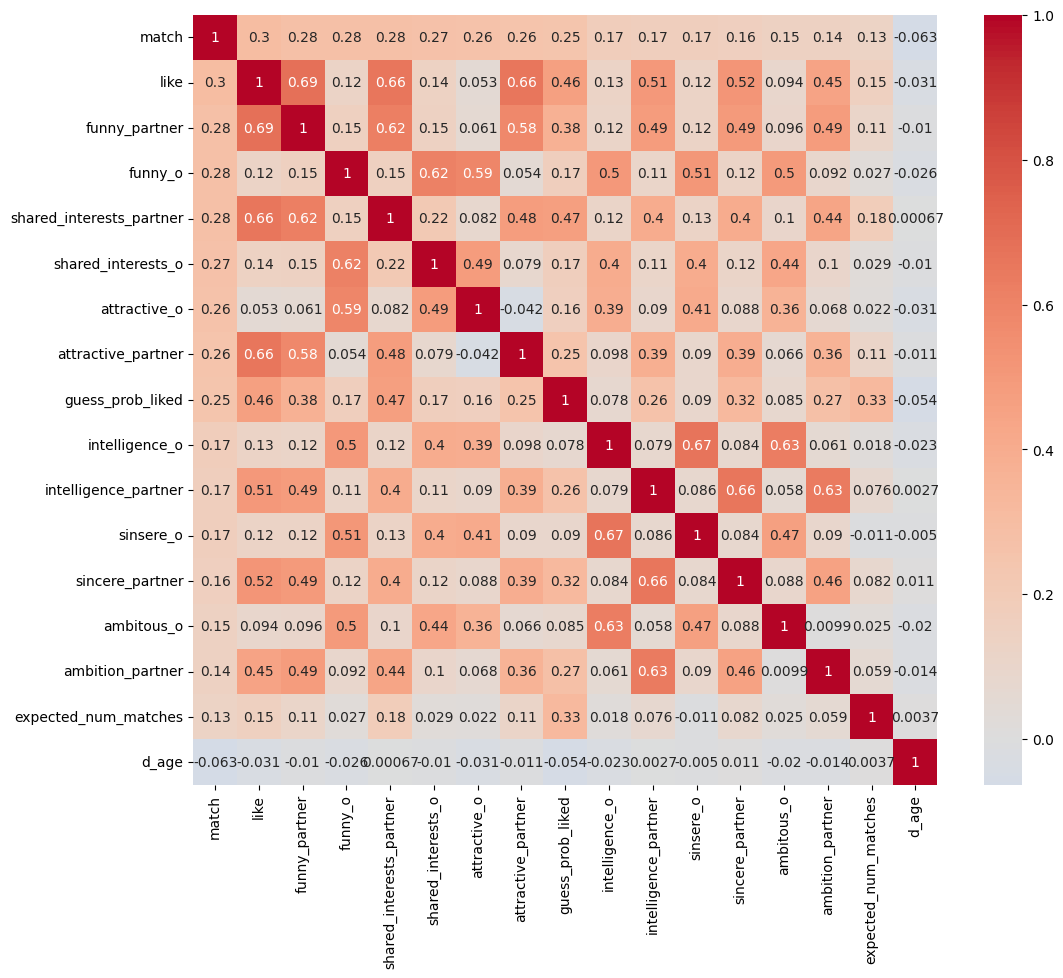

In [326]:
target_corr = df_clean.select_dtypes(include='number').corr()['match'].sort_values(ascending=False)
target_corr = target_corr.drop(["decision_o", "decision"], errors="ignore")
top_features = target_corr.abs().sort_values(ascending=False).head(17).index

plt.figure(figsize=(12,10))
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.show()

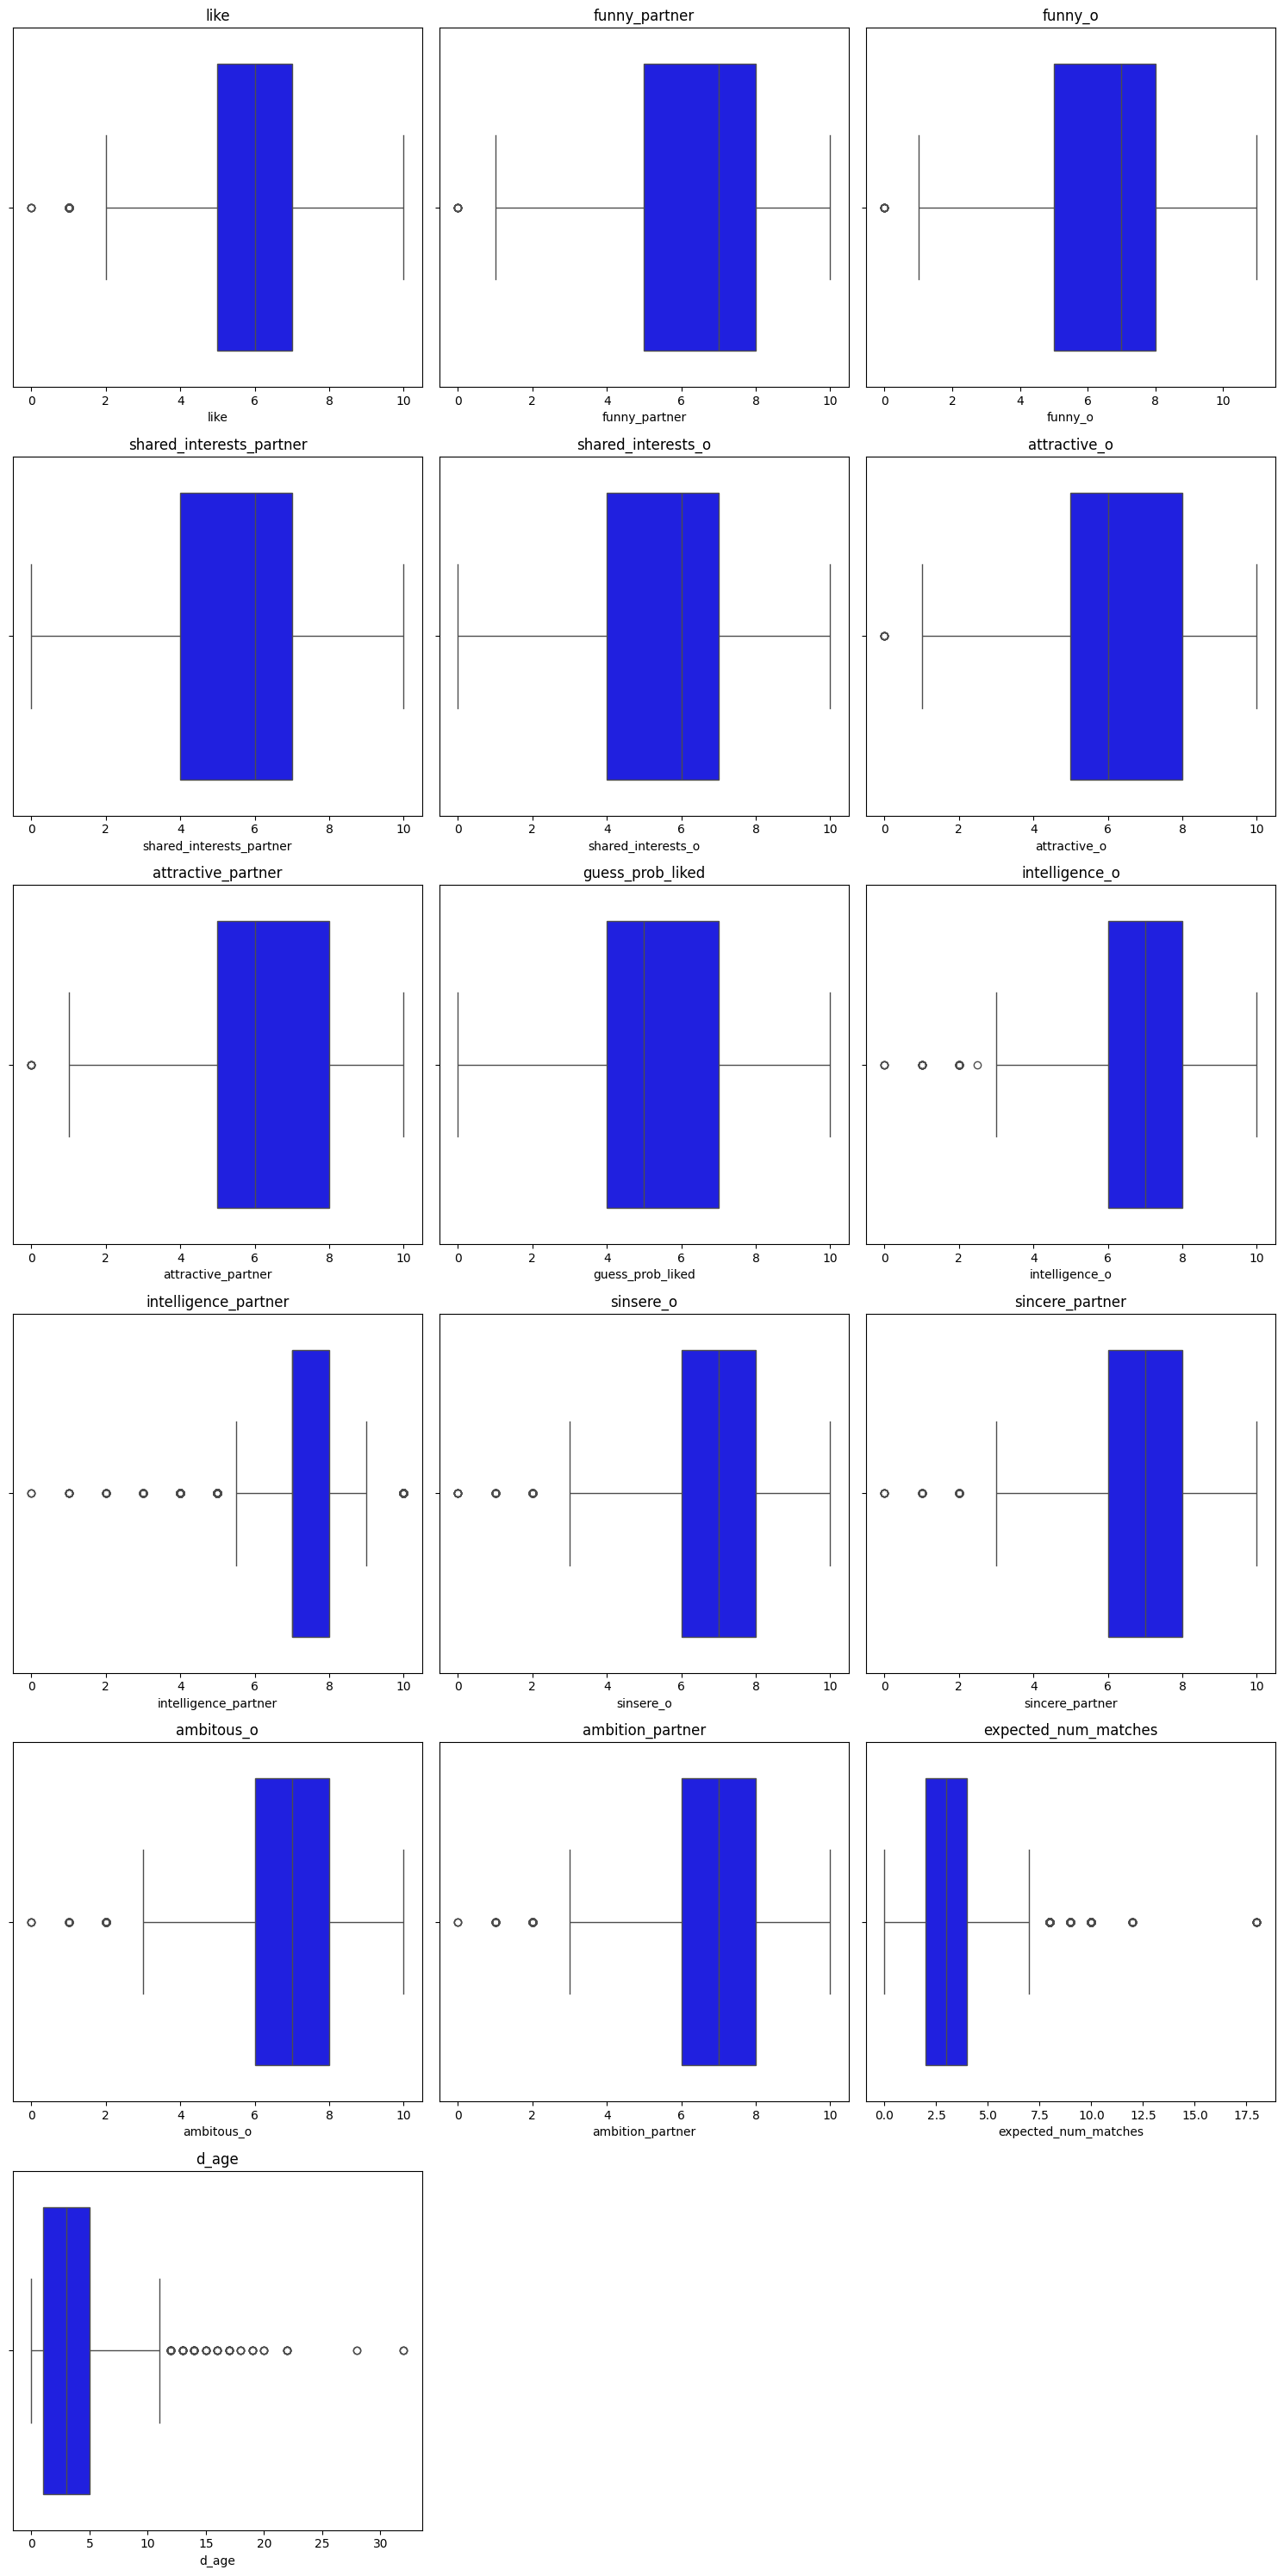

In [327]:
#Boxploty pre najviac korelujúce stĺpce, mimo tie čo majú binárnu hodnotu
cols = [c for c in top_features if df_clean[c].nunique() > 2]

n = len(cols)
rows = math.ceil(n / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    sns.boxplot(x=df_clean[col], ax=ax, color="blue")
    ax.set_title(col)
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Nahradim missing values realnym cislo -> pouzijem KNN imputer

#### Pozrieme sa kolko sme mali missing_values


In [328]:
df_clean.isnull().sum()

gender                             0
age                                0
age_o                              0
d_age                              0
race                               0
                                ... 
expected_happy_with_sd_people     14
expected_num_matches             931
like                              90
guess_prob_liked                 145
match                              0
Length: 62, dtype: int64

In [329]:
attributes_to_fill = [
"expected_num_matches"
,"shared_interests_partner"
,"ambition_partner"
,"funny_partner"
,"guess_prob_liked"
,"intelligence_partner"
,"sincere_partner"
,"like"
,"attractive_partner"
,"pref_o_shared_interests"
,"shared_interests_important"
,"intelligence"
,"attractive"
,"ambition"
,"funny"
,"sincere"
,"interests_correlate"
,"pref_o_ambitious"
,"pref_o_funny"
,"funny_important"
,"ambtition_important"
,"pref_o_attractive"
,"pref_o_intelligence"
,"pref_o_sincere"
,"reading"
,"tv"
,"sincere_important"
,"importance_same_race"
,"attractive_important"
,"museums"
,"art"
,"intellicence_important"
,"importance_same_religion"
,"expected_happy_with_sd_people"
,"yoga"
,"clubbing"
,"gaming"
,"hiking"
,"theater"
,"concerts"
,"movies"
,"dining"
,"sports"
,"shopping"
,"music"
,"tvsports"
,"exercise"
]

In [330]:
df_clean[attributes_to_fill].dtypes

expected_num_matches             float64
shared_interests_partner         float64
ambition_partner                 float64
funny_partner                    float64
guess_prob_liked                 float64
intelligence_partner             float64
sincere_partner                  float64
like                             float64
attractive_partner               float64
pref_o_shared_interests          float64
shared_interests_important       float64
intelligence                     float64
attractive                       float64
ambition                         float64
funny                            float64
sincere                          float64
interests_correlate              float64
pref_o_ambitious                 float64
pref_o_funny                     float64
funny_important                  float64
ambtition_important              float64
pref_o_attractive                float64
pref_o_intelligence              float64
pref_o_sincere                   float64
reading         

#### Riešenie outlierov

In [331]:
def identify_outliers_z(df, hranica = 3):
    mean = df.mean()
    std = df.std()
    z_skore = (df-mean)/std
    return df[np.abs(z_skore) > hranica]

indexy_z = set()

print("Počet outlierov")
for col in df_clean.select_dtypes(include=[np.number]):
    outliers_z = identify_outliers_z(df_clean[col])
    if len(outliers_z)>0:
        print(f"{col}: {len(outliers_z)}")
        indexy_z.update(outliers_z.index)

Počet outlierov
age: 55
age_o: 44
d_age: 87
pref_o_attractive: 133
pref_o_sincere: 85
pref_o_intelligence: 123
pref_o_funny: 60
pref_o_ambitious: 21
attractive_o: 7
sinsere_o: 43
intelligence_o: 49
funny_o: 12
ambitous_o: 43
attractive_important: 138
sincere_important: 85
intellicence_important: 82
funny_important: 60
ambtition_important: 22
attractive: 18
sincere: 128
intelligence: 55
funny: 77
ambition: 82
attractive_partner: 6
sincere_partner: 39
intelligence_partner: 38
funny_partner: 8
ambition_partner: 36
dining: 62
museums: 13
gaming: 65
reading: 9
theater: 13
movies: 59
concerts: 13
music: 73
interests_correlate: 4
expected_num_matches: 48
like: 4


### Riesenie vychylenych hodnot pomocou Z-score


Počet outlierov podľa z-skóre (|z| > 3):
d_age: 223


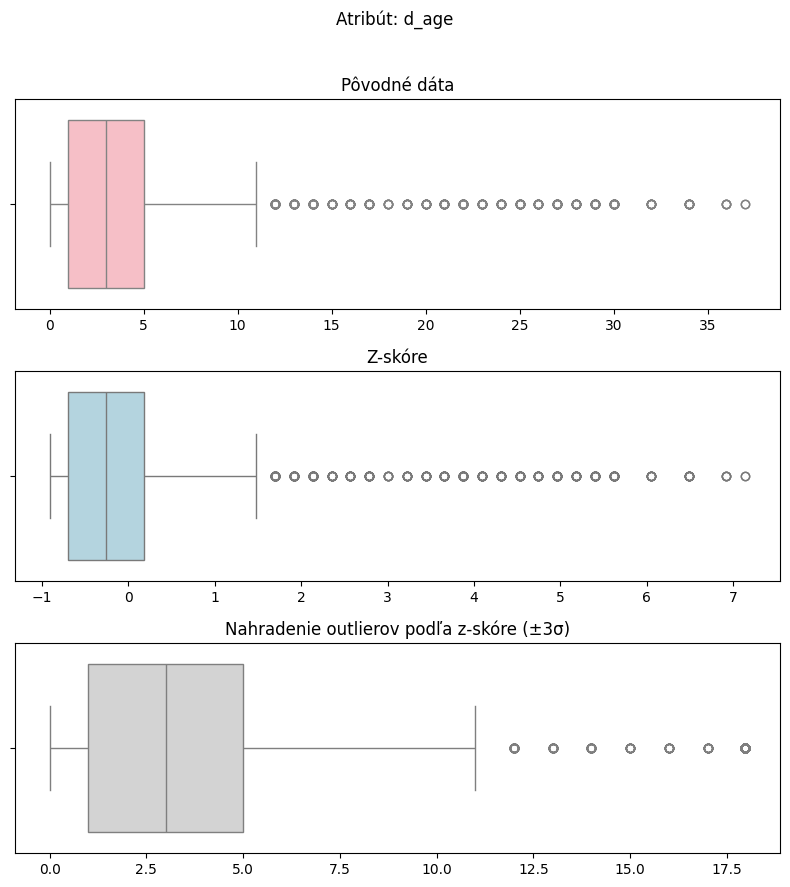

In [332]:
# to je pre z score
k = 3

#vybral som len tie ktoré majú aspoň 22 rôznych hodnôt
num_cols = df.select_dtypes(include='number').columns
columns_of_interest = [c for c in df_clean if df[c].nunique() > 22]

cols = [c for c in columns_of_interest if c in num_cols]
if not cols: 
    cols = list(num_cols)

means = df[cols].mean(skipna=True) #ignorujem nan hodnoty
stds  = df[cols].std(skipna=True) 
stds_safe = stds.replace(0, np.nan) #nechceme delit nulou tak radsej dame ako nan
z_df  = (df[cols] - means) / stds_safe
z_df  = z_df.replace([np.inf, -np.inf], np.nan)
lower = means - k * stds
upper = means + k * stds
df_wins = df.copy()
df_wins[cols] = df[cols].clip(lower=lower, upper=upper, axis=1)


print(f"\nPočet outlierov podľa z-skóre (|z| > {k}):")

pocet = (np.abs(z_df["d_age"]) > k).sum(skipna=True)
print(f"d_age: {pocet}")


fig, axes = plt.subplots(3, 1, figsize=(8, 9))
fig.suptitle("Atribút: d_age", y=0.98)
#povodne data
sns.boxplot(x=df["d_age"], ax=axes[0], color='lightpink')
axes[0].set_title("Pôvodné dáta")
axes[0].set_xlabel("")
 #z-score
sns.boxplot(x=z_df["d_age"], ax=axes[1], color='lightblue')
axes[1].set_title("Z-skóre")
axes[1].set_xlabel("")
#nahradim to podla z-score
sns.boxplot(x=df_wins["d_age"], ax=axes[2], color='lightgray')
axes[2].set_title(f"Nahradenie outlierov podľa z-skóre (±{k}σ)")
axes[2].set_xlabel("")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [333]:
print(columns_of_interest)

['age', 'age_o', 'd_age', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'interests_correlate']


Pred rozdelením dát ich musíme ešte:
- Náhodne premiešať (je vhodné si zvoliť random_state pre reprodukovateľnosť výsledkov)
- Stratifíkovať dáta podľa cieľovej premennej (match) - robí sa to vtedy keď je cieľová premenná nevyvážená (čo je náš prípad)
  - Chceme zabezpečiť, aby každá množina mala približne rovnaké zastúpenie každej kategórie


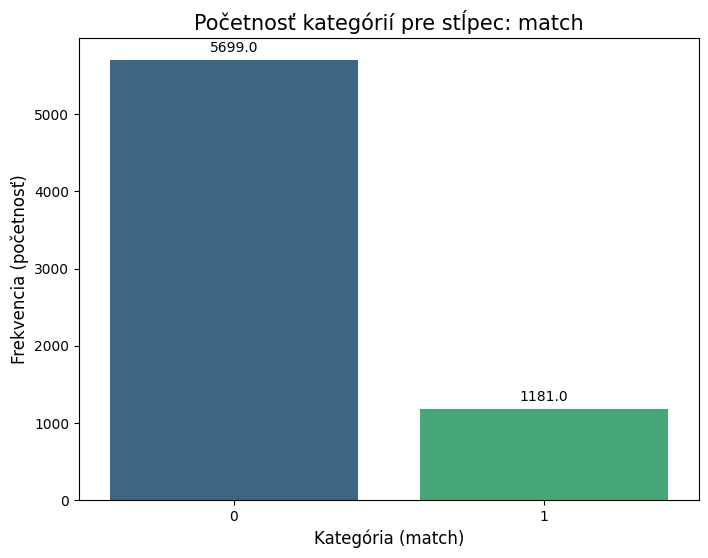

In [334]:
plt.figure(figsize=(8, 6))

# Funkcia sns.countplot automaticky vypočíta počet výskytov každej kategórie
ax = sns.countplot(x="match", data=df_clean, hue="match", legend=False, palette="viridis")

# Nastavenie popiskov a názvu
plt.title(f'Početnosť kategórií pre stĺpec: {"match"}', fontsize=15)
plt.xlabel(f'Kategória ({"match"})', fontsize=12)
plt.ylabel('Frekvencia (početnosť)', fontsize=12)

# Vloženie presných čísel (početnosti) nad každý stĺpec
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()


Rozdelíme si dáta na 3 množiny:
- Trénovacia množina (70% dát) - na trénovanie modelu
- Validačná množina (15% dát) - na testovani správnosti modelu počas tréningu
- Testovacia množina (15% dát) - na finálne otestovanie modelu

Tento pomer môže byť aj iný ale 70/15/15 je bežný štandard.



In [335]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    df_clean.drop(columns=['match']),
    df_clean['match'],
    test_size=0.15,
    random_state=69,
    stratify=df_clean['match']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # približne 15% z pôvodných dát
    random_state=69,
    stratify=y_temp
)

print(f"Tréningová množina: {X_train.shape[0]} vzoriek")
print(f"Validačná množina: {X_val.shape[0]} vzoriek")
print(f"Testovacia množina: {X_test.shape[0]} vzoriek")

Tréningová množina: 4815 vzoriek
Validačná množina: 1033 vzoriek
Testovacia množina: 1032 vzoriek


In [336]:
---
###                                                                                                      PIPELINE
---

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,...,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,like,guess_prob_liked
1709,female,21,21,0,European/Caucasian-American,European/Caucasian-American,1,8.0,10.0,'Economics; Sociology',...,5.0,6.0,5.0,9.0,3.0,0.47,6.0,1.0,10.0,9.0
814,female,23,22,1,European/Caucasian-American,European/Caucasian-American,1,10.0,9.0,'social work',...,7.0,6.0,9.0,10.0,4.0,0.65,3.0,3.0,3.0,10.0
1415,male,39,23,16,European/Caucasian-American,European/Caucasian-American,1,1.0,1.0,'Social Work',...,8.0,6.0,8.0,2.0,7.0,0.67,5.0,5.0,10.0,3.0
3746,female,27,27,0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,4.0,4.0,Genetics,...,7.0,9.0,9.0,5.0,3.0,0.43,6.0,4.0,5.0,5.0
6239,male,30,24,6,'Black/African American',European/Caucasian-American,0,1.0,1.0,'International Affairs',...,9.0,7.0,9.0,9.0,5.0,0.18,6.0,1.0,3.0,3.0


Aké také čistenie field, pred pipeline

In [46]:
class FieldCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, replacements=None):
        # replacment čo nás napadlo
        self.replacements = replacements or {
            'eng': 'engineering',
            'engineer': 'engineering',
            'computer science': 'cs',
            'comp sci': 'cs',
            'information technology': 'cs',
            'law school': 'law',
            'psych': 'psychology',
            'psychological': 'psychology',
            'biz': 'business',
            'econ': 'economics',
            'bio': 'biology',
            'bioinformatics': 'biology',
            'edu': 'education',
            'teacher': 'education',
            'med': 'medicine',
            'pre med': 'medicine',
            'art history': 'arts',
            'art': 'arts'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        col = X.columns[0]
        s = X[col].astype(str).str.lower().str.strip()
        s = s.apply(lambda x: re.sub(r'[^a-z\s]', '', x))

        def normalize(x):
            for k, v in self.replacements.items():
                if k in x:
                    return v
            return x

        s = s.apply(normalize)

        s = s.replace(['nan', 'none', 'unknown', '', ' '], np.nan)
        s = s.fillna('missing')

        X[col] = s
        return X

### Vytvorili sme PipeLine, kde sme data najprv zmenili všetky kategorické dáta na numerické a potom sme dáta vyscalovali.

In [337]:
gender_races_cols = ['race','race_o','gender']
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
field_cols = ['field']

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

race_gender_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

field_transformer = Pipeline(steps=[
    ('clean', FieldCleaner()),
    ('target', TargetEncoder(
        cols=['field'],
        smoothing=50.0,
        handle_missing='value',
        handle_unknown='value'
    )),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('gen_race', race_gender_transformer, gender_races_cols),
        ('field', field_transformer, field_cols)
    ],
    remainder='drop'
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

final_pipeline.fit(X_train, y_train)

n_features = preprocessor.transform(X_train[:5]).shape[1]

### Multilayer perceptron

In [ ]:
# Model
class LazyMLP(nn.Module):
    def __init__(self, hidden=[256,128,64], dropout=0.2):
        super().__init__()
        layers = [nn.LazyLinear(hidden[0]), nn.ReLU(), nn.Dropout(dropout)]
        for i in range(1, len(hidden)):
            layers += [nn.Linear(hidden[i-1], hidden[i]), nn.ReLU(), nn.Dropout(dropout)]
        layers += [nn.Linear(hidden[-1], 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(1)

class SetPosWeight(Callback):
    def on_train_begin(self, net, X, y):
        y = np.asarray(y).astype(np.float32)
        pos = y.sum()
        neg = len(y) - pos
        w = (neg / max(pos, 1.0))
        net.criterion_.pos_weight = torch.tensor([w], device=net.device, dtype=torch.float32)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = NeuralNetBinaryClassifier(
    module=LazyMLP,
    max_epochs=20,
    lr=5e-3,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.BCEWithLogitsLoss,
    batch_size=512,
    iterator_train__shuffle=True,
    train_split=None,
    device=device,
    y_tensor_transform=lambda y: y.float(),
    callbacks=[
        EpochScoring('f1', on_train=True, lower_is_better=False, name='train_f1'),
        EarlyStopping(monitor='train_f1', patience=3, lower_is_better=False, load_best=True),
        SetPosWeight(),
    ],
)


In [53]:
to_float32 = FunctionTransformer(lambda X: np.asarray(X, dtype=np.float32), validate=False)

pre = final_pipeline.named_steps['preprocessor']

pipe = Pipeline([
    ('pre', pre),
    ('to_np', to_float32),
    ('clf', net),
])

In [54]:
param_grid = {
    'clf__lr': [1e-3, 5e-3, 1e-2],
    'clf__module__hidden': [[256,128,64], [128,64], [512,256,128]],
    'clf__module__dropout': [0.0, 0.2, 0.5],
    'clf__batch_size': [256, 512, 1024],
    'clf__optimizer': [torch.optim.Adam, torch.optim.RMSprop],
    'clf__max_epochs': [15, 30],
}

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=1,
    refit=True,
)

y_train_float = np.asarray(y_train, dtype=np.float32)

gs.fit(X_train, y_train_float)

print("Best params:", gs.best_params_)
print("CV best f1:", gs.best_score_)
best_model = gs.best_estimator_

  epoch    train_f1    train_loss     dur
-------  ----------  ------------  ------
      1      0.4625        1.0332  0.0340
      2      0.5051        0.8277  0.0470
      3      0.5275        0.7937  0.0320
      4      0.5646        0.7594  0.0370
      5      0.5794        0.7042  0.0330
      6      0.5931        0.6827  0.0330
      7      0.5849        0.6662  0.0374
      8      0.6166        0.6142  0.0400
      9      0.6389        0.5803  0.0406
     10      0.6619        0.5337  0.0480
     11      0.6926        0.4755  0.0478
     12      0.7241        0.4295  0.0469
     13      0.7548        0.3882  0.0425
     14      0.7367        0.3890  0.0504
     15      0.7766        0.3483  0.0521
  epoch    train_f1    train_loss     dur
-------  ----------  ------------  ------
      1      0.4010        1.0703  0.0499
      2      0.5051        0.8462  0.0462
      3      0.5367        0.7744  0.0435
      4      0.5545        0.7359  0.0439
      5      0.5746        0.7014 

In [55]:
y_pred_val = best_model.predict(X_val)
y_proba_val = best_model.predict_proba(X_val)[:, 0]
print("VAL f1:", f1_score(y_val, y_pred_val))
print("VAL logloss:", log_loss(y_val, y_proba_val, labels=[0,1]))

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 0]
print("TEST f1:", f1_score(y_test, y_pred_test))
print("TEST logloss:", log_loss(y_test, y_proba_test, labels=[0,1]))

VAL f1: 0.5399568034557235
VAL logloss: 4.2963560553872355
TEST f1: 0.5387931034482759
TEST logloss: 4.302339346164017
